In [2]:
import os
import rasterio
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from scipy.stats import linregress as lr
import math as mt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
from PIL import Image
import random

In [3]:
def box_count(raster: np.ndarray, box_size: int):
    mask = ~(raster == -9999)
    # print(mask)
    rows, cols = raster.shape
    total_box_count = 0 
    for i in range(0, rows, box_size):
        for j in range(0, cols, box_size):
            end_row = min(i + box_size, rows)
            end_col = min(j + box_size, cols)
            # print(f"For location {i}, {j}, end row is {end_row} and end col is {end_col}")
            current_slice = raster[i:end_row, j:end_col]
            current_mask = mask[i:end_row, j:end_col]

            # valid_vals = current_slice[current_mask] # Original Location
            # if valid_vals.size > 0: # Original
            if np.all(current_mask): # Updated such that if any values are invalid (a.k.a boxes are border boxes) then don't compute
                valid_vals = current_slice[current_mask]
                max_val = np.max(valid_vals)
                min_val = np.min(valid_vals)
                # print(f"max_val = {max_val}, min_val={min_val}")
                hdiff = max_val - min_val # if box_size = 1 - hdiff = 0 // Times 2 to account for 2m by 2m by 1m scale
                box_count = mt.ceil(hdiff / (2*box_size))
                total_box_count += box_count
        # print(f"Total box count for box size {size} is {box_count_for_size}")
    return total_box_count

def fractal_dimension_test_flat(tif_file: str, box_sizes: List[int], pdf: PdfPages, save_fig: bool):
    with rasterio.open(tif_file) as src:
        image = src.read(1)
        
    flat_array = np.array(image)
    for i in range(flat_array.shape[0]):
        for j in range(flat_array.shape[1]):
              flat_array[i][j] = random.randint(1000, 1010)

    counts = [box_count(flat_array, size) for size in box_sizes]
    log_eps = np.log10(1 / np.array(box_sizes))
    log_counts = np.log10(counts)
    print(f"box_counts is {counts}; log_eps is {log_eps}; log_box_counts is {log_counts}")

    slope, intercept = np.polyfit(log_eps, log_counts, 1)
    dateyear = tif_file.split('_')[3]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(log_eps, log_counts, 'o', label='Log-Log Data')
    ax.plot(log_eps, slope * log_eps + intercept, 'r', label=f'Fit: slope = {slope:.4f}')
    ax.set_xlabel('log(1/ε)')
    ax.set_ylabel('log(N(ε))')
    ax.set_title(f'Fractal Dimension Estimation\n{dateyear}')
    ax.legend()
    ax.grid(True)
    if save_fig:
        pdf.savefig(fig)

    return slope

        
        

box_counts is [457500, 114375, 28764, 7238, 1833, 480, 120]; log_eps is [-1.20411998 -1.50514998 -1.80617997 -2.10720997 -2.40823997 -2.70926996
 -3.01029996]; log_box_counts is [5.6603911  5.05833111 4.45884928 3.85961858 3.26316246 2.68124124
 2.07918125]


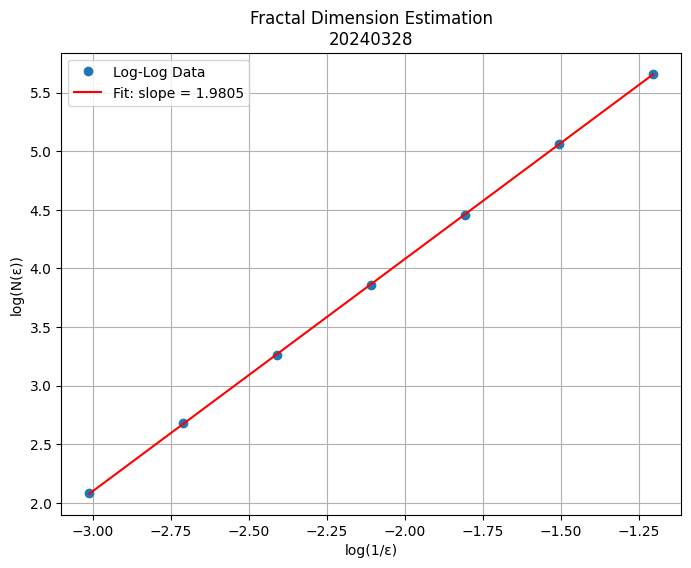

In [10]:
path = 'updated-datasets/SETSM_s2s041_WV03_20240328_1040010092555600_1040010094CC8500_2m_seg1_dem.tif'
list_of_box_sizes = np.array([16 * 2**i for i in range(7) if 16 * 2**i <= 2048])
with PdfPages("rahhhh.pdf") as pdf:
    flat_surface_slope = fractal_dimension_test_flat(path, list_of_box_sizes, pdf, False)